In [85]:
import base
import distance
import greedy
import ioUtils
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [86]:
def get_stats(data_):
    summary_df = data_.groupby('trajID').agg({
        'lat': ['min', 'max', 'std'],
        'lon': ['min', 'max', 'std'],
        's_trajID': ['count']
    })
    summary_df.columns = summary_df.columns.map('_'.join).str.strip('_')
    summary_df['len_lat'] = summary_df['lat_max'] - summary_df['lat_min']
    summary_df['len_lon'] = summary_df['lon_max'] - summary_df['lon_min']
    summary_df['mean_len'] = (summary_df['len_lat'] + summary_df['len_lon']) / 2
    summary_df['mean_std'] = (summary_df['lat_std'] + summary_df['lon_std']) / 2
    summary_df = summary_df.sort_values('mean_std').reset_index()
    return summary_df

In [87]:
def run_algo(txtfile, rmin_, rmax_):
    trajs = ioUtils.readTrajsFromTxtFile('data/'+txtfile)
    rmin, rmax = rmin_, rmax_
    print("Computing Frechet distances ...")
    distPairs1 = distance.process(trajs, rmin, rmax)
    distPairs2 = {}
    for k, v in distPairs1.items():
        pth, trID, dist, straj = k[0], k[1].trajID, v, k[1]
        if (pth, trID) in distPairs2:
            distPairs2[(pth, trID)].append((straj, dist))
        else:
            distPairs2[(pth, trID)] = [(straj, dist)]
    print("Computing prerequisite data structures for greedy algorithm ...")
    (strajCov, ptStraj, strajPth, trajCov) = greedy.preprocessGreedy(trajs, distPairs2)
    c1, c2, c3 = 1,1,1

    print("Running greedy algorithm ...")
    retVal = greedy.runGreedy(trajs, distPairs2, strajCov, ptStraj, strajPth, trajCov, c1, c2, c3)
    for k,v in retVal[0].items():
        print("-"*60)
        print(k)
        #print(type(v))
        for x in v:
            print(x)
            print(x.bounds)
    return retVal

In [88]:
data = pd.read_csv('data/result.csv')

In [89]:
data['BaseDateTime'] = pd.to_datetime(data['BaseDateTime'])

In [90]:
data = data.sort_values('BaseDateTime')

In [91]:
data.head()

,trajId,BaseDateTime,LAT,LON
98,2,2017-11-07 01:40:00,-71.152782,42.310704
36,1,2017-11-07 01:40:00,-71.204796,42.336088
37,1,2017-11-07 01:44:00,-71.201878,42.340275
99,2,2017-11-07 01:44:00,-71.146259,42.315274
38,1,2017-11-07 01:49:00,-71.198101,42.344843


In [92]:
count_df = data.groupby('trajId').size().reset_index(name='count').sort_values('count', ascending=False)
count_df = count_df.loc[count_df['count'].isin(range(37,71))]
count_df

,trajId,count
1,1,62
2,2,37


In [93]:
df = data.loc[data['trajId'].isin(count_df.head(70)['trajId'])]

In [94]:
df['trajID'] = df['trajId'].map(dict(zip(df['trajId'].unique(), list(range(0, len(df['trajId'].unique()))))))

C:\Users\nikun\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [95]:
df['s_trajID'] = 't'+ df['trajID'].apply(str)

C:\Users\nikun\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [96]:
df['BaseDateTime'] = pd.to_datetime(df['BaseDateTime'])

C:\Users\nikun\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [97]:
fig = plt.figure(figsize=(15,10))
sns.lineplot(x='LAT', y='LON', data=df, hue='s_trajID')
plt.show()

AttributeError: module 'seaborn' has no attribute 'lineplot'

<Figure size 1080x720 with 0 Axes>

In [98]:
df[['trajID','BaseDateTime', 'LON', 'LAT']].to_csv('data/results.txt',index=False, header=None)

In [101]:
retVal = run_algo('results.txt',0.01 , 0.1)

Computing Frechet distances ...
Computing prerequisite data structures for greedy algorithm ...
Running greedy algorithm ...
num of points is 99
num of points is 37
------------------------------------------------------------
Pathlet TrajID 1 ; bounds (0, 61)
Subtraj TrajID 1 ; bounds (0, 61)
(0, 61)
------------------------------------------------------------
Pathlet TrajID 0 ; bounds (0, 36)
Subtraj TrajID 0 ; bounds (0, 36)
(0, 36)


In [115]:
len(retVal[0])


1

In [76]:
len(retVal[2])

9

In [17]:
data = df[['trajID','BaseDateTime', 'LON', 'LAT']].reset_index(drop=True)
data['c'] = 0

In [18]:
data_dict = {}
for x in data['trajID'].unique():
    data_dict[x] = data.loc[data['trajID'] == x].reset_index(drop=True)

In [19]:
list_put=[]
line_ = 1
for k,v in retVal[0].items():
    print("-"*60)
    print(k)
    #print(k.trajID)
    list_put.append(k.trajID)
    #print(type(v))
    for x in v:
        print(x)
        print(x.bounds)
        data_dict[x.trajID].loc[x.bounds[0]: x.bounds[1], 'c'] = line_
    line_+=1

------------------------------------------------------------
Pathlet TrajID 41 ; bounds (0, 34)
Subtraj TrajID 41 ; bounds (0, 34)
(0, 34)
Subtraj TrajID 16 ; bounds (0, 44)
(0, 44)
Subtraj TrajID 0 ; bounds (0, 27)
(0, 27)
Subtraj TrajID 38 ; bounds (0, 36)
(0, 36)
Subtraj TrajID 3 ; bounds (0, 35)
(0, 35)
Subtraj TrajID 39 ; bounds (8, 45)
(8, 45)
Subtraj TrajID 49 ; bounds (4, 29)
(4, 29)
Subtraj TrajID 52 ; bounds (3, 36)
(3, 36)
Subtraj TrajID 29 ; bounds (0, 31)
(0, 31)
Subtraj TrajID 40 ; bounds (0, 29)
(0, 29)
------------------------------------------------------------
Pathlet TrajID 23 ; bounds (0, 44)
Subtraj TrajID 23 ; bounds (0, 44)
(0, 44)
Subtraj TrajID 22 ; bounds (2, 56)
(2, 56)
Subtraj TrajID 14 ; bounds (0, 47)
(0, 47)


In [27]:
list_put
list_ignore = [ 1,  2, 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15,
       17, 19, 20, 21, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35,
       36, 42, 43, 44, 45, 46, 47, 48, 51, 53, 55, 56,
       57, 58, 59, 60, 61]

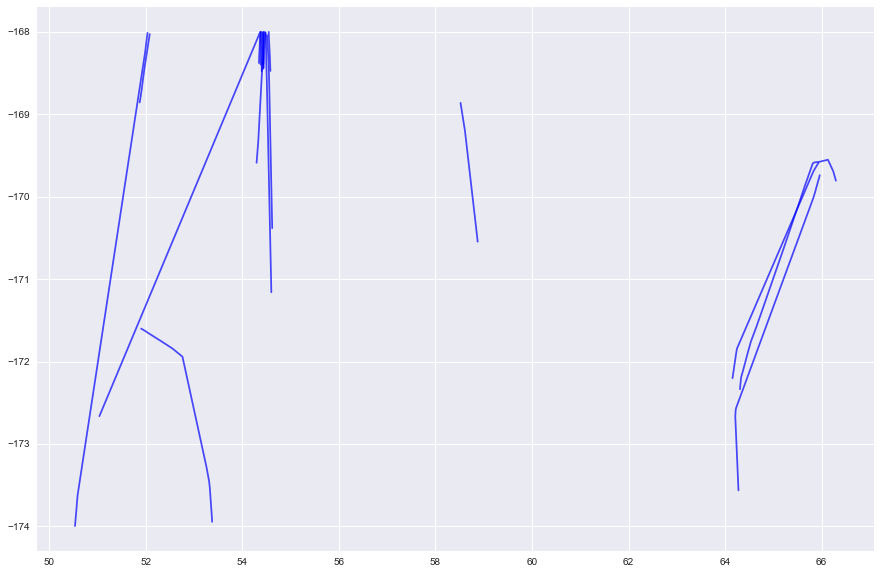

In [30]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for trajID, traj_df in data_dict.items():
    if not trajID in list_ignore:
    #print(trajID)
    #display(summary_df.loc[trajID])
        ax.plot(traj_df['LAT'], traj_df['LON'], color='b', alpha=0.7)
    #sns.lineplot(x='LAT', y='LON', data=traj_df, hue='c')
    #ax.plot(traj_df['LAT'].loc[traj_df['c'] == 1], traj_df['LON'].loc[traj_df['c'] == 1], color='r', linewidth=1)
    #ax.plot(traj_df['LAT'].loc[traj_df['c'] == 2], traj_df['LON'].loc[traj_df['c'] == 2], color='g', linewidth=1)
plt.show()

In [35]:
data['s_trajID'] = 't' + data['trajID'].apply(str)


In [36]:
unused_df = pd.DataFrame({
    'trajID': [x.trajID for x in retVal[2]],
    'lat': [x.lat for x in retVal[2]],
    'lon': [x.lon for x in retVal[2]]
})

In [37]:
unused_data_dict = {}
for x in unused_df['trajID'].unique():
    unused_data_dict[x] = unused_df.loc[unused_df['trajID'] == x].reset_index(drop=True)

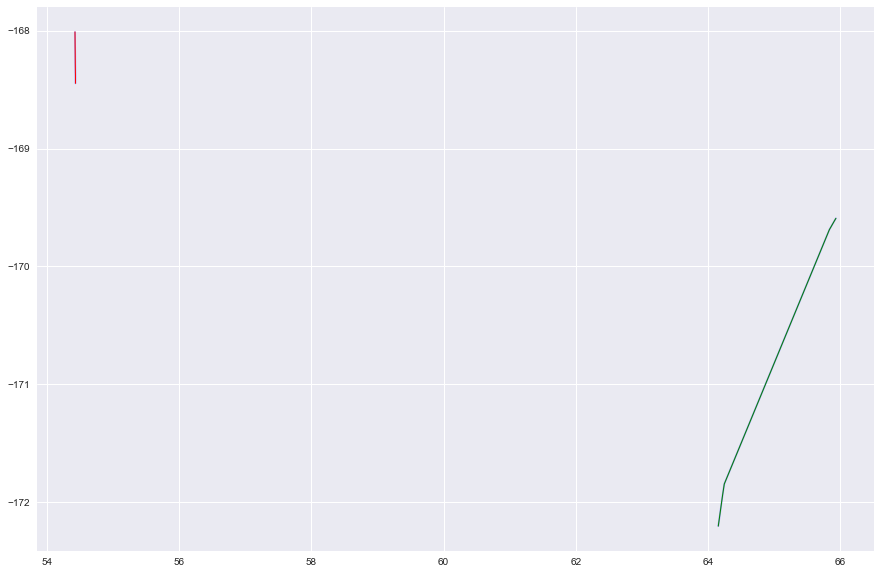

In [40]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for trajID, traj_df in data_dict.items():
    if not trajID in list_ignore:
        if trajID in list_put:
        #print(trajID)
        #display(summary_df.loc[trajID])
            ax.plot(traj_df['LAT'], traj_df['LON'], color='b', alpha=0.3)
        #sns.lineplot(x='LAT', y='LON', data=traj_df, hue='c')
            ax.plot(traj_df['LAT'].loc[traj_df['c'] == 1], traj_df['LON'].loc[traj_df['c'] == 1], color='r', linewidth=1)
            ax.plot(traj_df['LAT'].loc[traj_df['c'] == 2], traj_df['LON'].loc[traj_df['c'] == 2], color='g', linewidth=1)
        #if trajID in list_c:
            #ax.plot(traj_df['LAT'], traj_df['LON'], color='b', alpha=0.5)
for trajID, traj_df in unused_data_dict.items():
    ax.plot(traj_df['lon'], traj_df['lat'], color='b', alpha=0.5)
plt.show()